# Introduction

In this notebook I will explore three different models for segmentation on this CamVid Dataset which has 32 classes. The models that I explored here are-
   
   - **Fully Convolutional Network model :** This model is proposed by [1](https://arxiv.org/pdf/1411.4038). Moreover, I also have insights from [here] (https://github.com/khalequzzamanlikhon/DeepLearning-ComputerVision/blob/master/08-Segmentation-Detection/01-Semantic-Segmentation.ipynb). Inspired by these I have defined a FCN using resnet50 as backbone followed by custom decoders.
   
   - **U-net architecture with attention mechanism :** I have defined a unet architecture with attentin mechanism
   
   - **Deeplabv3+ model :** Inspired by [2](https://arxiv.org/pdf/1802.02611), I have applied deeplabv3+ model here on this dataset.
   
   
Applying and comparing these models, I struggled to get a good mIoU. Even with the deeplabv3+. So my request to you, if you have come across this notebook and find anything that might improve the model's performance regarding mIoU please leave a message [here](https://www.linkedin.com/in/khalequzzaman-likhon/) mentioning this notebook. You can also find this notebook at [github](https://github.com/khalequzzamanlikhon/Image-Segmentation-CamVid)

In [1]:
pip install torch torchvision numpy opencv-python

Note: you may need to restart the kernel to use updated packages.


# Loading libraries

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.models import resnet18
from torchvision.models import resnet50
import torchvision.models.segmentation as segmentation 
from torchviz import make_dot
from torch.autograd import Variable
from sklearn.metrics import jaccard_score

# Setting device

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preperation

In [5]:
import pandas as pd

def load_color_mapping(csv_path):
    # Load the CSV file
    df = pd.read_csv(csv_path)
    # Create a mapping from (r, g, b) to the class index
    color_mapping = {(row['r'], row['g'], row['b']): idx for idx, row in df.iterrows()}
    return color_mapping,df


In [6]:
color_mapping,df=load_color_mapping("/kaggle/input/camvid/CamVid/class_dict.csv")
print(color_mapping)

{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31}


## Custom Dataset class

In [7]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.color_mapping = color_mapping
        self.transform = transform
        self.image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
        self.label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and label
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        label = cv2.imread(self.label_files[idx]) # Load as RGB
        label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        #Convert the RGB label to class indices
        label = self.convert_rgb_to_class(label)
#         Apply transformations, if any
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label.long()

    def convert_rgb_to_class(self, label):
        """Convert RGB mask to class indices."""
        # Create an empty mask with the same shape as the label
        class_mask = np.zeros((label.shape[0], label.shape[1]), dtype=int)

        # Iterate over each pixel and assign the class index based on RGB value
        for rgb, class_idx in self.color_mapping.items():
            mask = (label[:, :, 0] == rgb[0]) & (label[:, :, 1] == rgb[1]) & (label[:, :, 2] == rgb[2])
            class_mask[mask] = class_idx

        return class_mask


## Data augmentation

In [12]:
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(400, 520),  
            A.RandomCrop(height=352, width=480),  
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5), 
            A.GaussianBlur(blur_limit=(3, 5), p=0.3),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            A.Normalize(mean=(0.390, 0.405, 0.414), std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(352, 480), 
            A.Normalize(mean=(0.390, 0.405, 0.414), std=(0.274, 0.285, 0.297)),
            ToTensorV2()
        ])


In [13]:
# Instantiate datasets with the color map
train_dataset = CamVidDataset('/kaggle/input/camvid/CamVid/train', '/kaggle/input/camvid/CamVid/train_labels', color_mapping, transform=get_transforms(train=True))
val_dataset = CamVidDataset('/kaggle/input/camvid/CamVid/val', '/kaggle/input/camvid/CamVid/val_labels', color_mapping, transform=get_transforms(train=False))
test_dataset = CamVidDataset('/kaggle/input/camvid/CamVid/test', '/kaggle/input/camvid/CamVid/test_labels', color_mapping, transform=get_transforms(train=False))

## visualizing few input and label images

In [14]:
import matplotlib.pyplot as plt


def visualize_samples(dataset, color_mapping, num_samples=3):
    # Create a reverse mapping from class index to RGB values for visualization
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    
    for i in range(num_samples):
        # Get a sample from the dataset
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
        label = label.numpy()


        # Create an RGB mask for visualization
        label_rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        for class_idx, rgb in reverse_color_mapping.items():
            label_rgb[label == class_idx] = rgb

        # Plot the image and label
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Sample {i + 1} - Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(label_rgb)
        axs[i, 1].set_title(f'Sample {i + 1} - Label')
        axs[i, 1].axis('off')
        

    plt.tight_layout()
    plt.show()


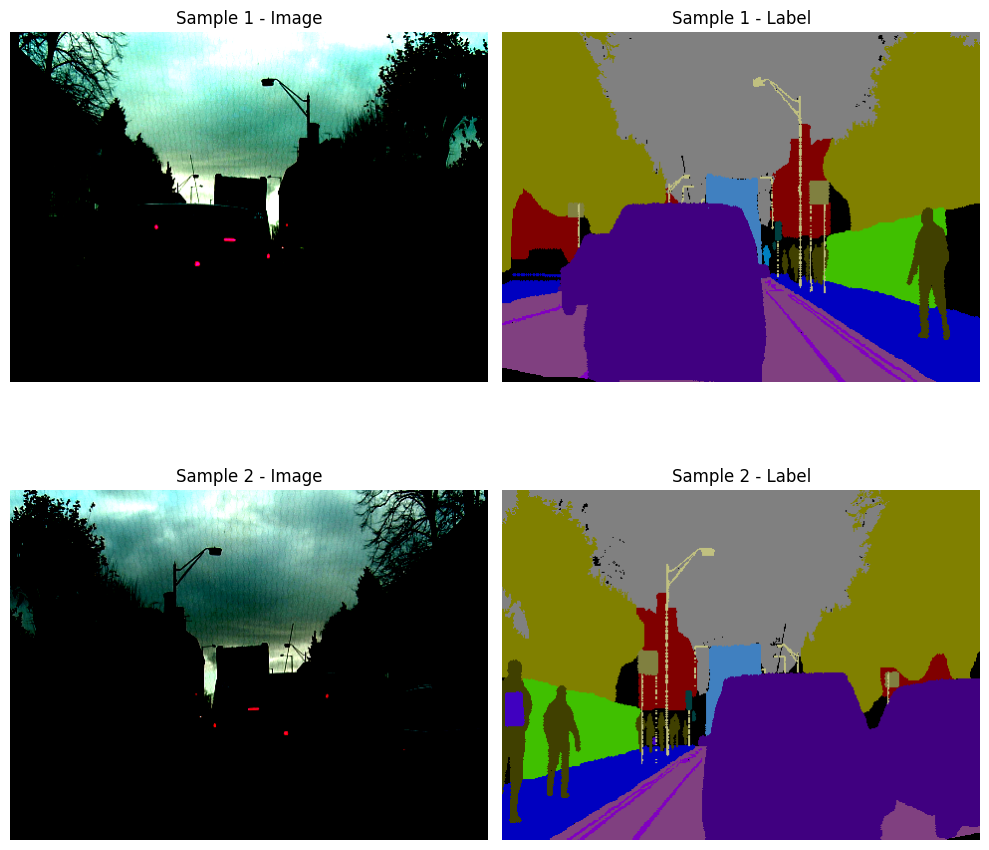

In [15]:
visualize_samples(train_dataset,color_mapping, num_samples=2)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [17]:
# check shape of image and label
for i, (image, mask) in enumerate(train_loader):
    print(f"Batch {i}: Image shape: {image.shape}, Mask shape: {mask.shape}")
    break  


Batch 0: Image shape: torch.Size([4, 3, 352, 480]), Mask shape: torch.Size([4, 352, 480])


# Implementing the Fully Convolutional Network (FCN) -- Scratch

In [19]:
class FCNSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(FCNSegmentation, self).__init__()
        
        # ResNet-50 as encoder backbone
        resnet = models.resnet50(pretrained=True)
        
        # Encoder using ResNet50 layers, excluding the fully connected part
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        
        # Decoder for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(128, num_classes, kernel_size=4, stride=2, padding=1),
            nn.Upsample(size=(352, 480), mode='bilinear', align_corners=True)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




# U-net Using efficientnet


In [21]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNetResNet50(nn.Module):
    def __init__(self, num_classes):
        super(UNetResNet50, self).__init__()
        
        # Pre-trained ResNet-50 backbone
        resnet = resnet50(weights='IMAGENET1K_V1')
        
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder2 = nn.Sequential(resnet.maxpool, resnet.layer1)
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4
        
        # Decoder with attention
        self.attention5 = AttentionBlock(F_g=2048, F_l=1024, F_int=512)
        self.decoder5 = nn.Sequential(
            nn.Conv2d(2048 + 1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.attention4 = AttentionBlock(F_g=1024, F_l=512, F_int=256)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.attention3 = AttentionBlock(F_g=512, F_l=256, F_int=128)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.attention2 = AttentionBlock(F_g=256, F_l=64, F_int=32)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)  # (B, 64, H/2, W/2)
        e2 = self.encoder2(e1) # (B, 256, H/4, W/4)
        e3 = self.encoder3(e2) # (B, 512, H/8, W/8)
        e4 = self.encoder4(e3) # (B, 1024, H/16, W/16)
        e5 = self.encoder5(e4) # (B, 2048, H/32, W/32)
        
        # Decoder with attention
        d5 = F.interpolate(e5, size=e4.size()[2:], mode='bilinear', align_corners=True)
        e4_att = self.attention5(d5, e4)
        d5 = torch.cat((d5, e4_att), dim=1)
        d5 = self.decoder5(d5)
        
        d4 = F.interpolate(d5, size=e3.size()[2:], mode='bilinear', align_corners=True)
        e3_att = self.attention4(d4, e3)
        d4 = torch.cat((d4, e3_att), dim=1)
        d4 = self.decoder4(d4)
        
        d3 = F.interpolate(d4, size=e2.size()[2:], mode='bilinear', align_corners=True)
        e2_att = self.attention3(d3, e2)
        d3 = torch.cat((d3, e2_att), dim=1)
        d3 = self.decoder3(d3)
        
        d2 = F.interpolate(d3, size=e1.size()[2:], mode='bilinear', align_corners=True)
        e1_att = self.attention2(d2, e1)
        d2 = torch.cat((d2, e1_att), dim=1)
        d2 = self.decoder2(d2)
        
        # Final output
        output = self.final_conv(d2)
        output = F.interpolate(output, size=(352,480), mode='bilinear', align_corners=True)
        
        return output


## Deeplabv3

In [23]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        # Load the pre-trained DeepLabV3+ model
        self.model = segmentation.deeplabv3_resnet50(pretrained=True)
        
        # Modify the classifier to output num_classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
        
    def forward(self, x):
        # Forward pass
        return self.model(x)['out']


# Visualize model architecture

In [24]:
!pip install torchviz

# Training 

## callbacks(early stopping)

In [25]:
import torch.optim as optim
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# loss function combined (dice + jaccard )

In [26]:
# dice loss

def dice_loss(pred, target, smooth=1e-6):
    # Convert target to one-hot encoding
    # target shape: (batch_size, height, width) -> (batch_size, num_classes, height, width)
    target = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    pred = pred.contiguous()
    target = target.contiguous()

    # Compute Dice loss
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / 
                (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))

    # Average loss across all classes
    return loss.mean()

# Jaccard Loss

class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Convert y_true to one-hot encoding (assumed input as (batch_size, height, width))
        y_true = F.one_hot(y_true, num_classes=y_pred.shape[1]).permute(0, 3, 1, 2).float()

        # Apply sigmoid to y_pred for binary/multiclass segmentation if necessary
        y_pred = torch.sigmoid(y_pred)

        # Flatten the tensors
        y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
        y_true = y_true.contiguous().view(y_true.shape[0], -1)

        # Compute intersection and union
        intersection = (y_pred * y_true).sum(dim=1)
        union = y_pred.sum(dim=1) + y_true.sum(dim=1) - intersection

        # Compute Jaccard Index (IoU)
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Return Jaccard loss (1 - IoU)
        return 1 - iou.mean()


    
# Combined Loss (dice + jaccard)
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, jaccard_weight=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.jaccard_weight = jaccard_weight
        self.dice_loss = dice_loss
        self.jaccard_loss = JaccardLoss(smooth=smooth)
    
    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        jaccard = self.jaccard_loss(y_pred, y_true)
        return self.dice_weight * dice + self.jaccard_weight * jaccard

    
combined_loss = CombinedLoss(dice_weight=0.7, jaccard_weight=0.3)


## Training setup

In [27]:
model_fcn = FCNSegmentation(num_classes=32).to(device)  
model_unet = UNetResNet50(num_classes=32).to(device)
model_deeplab = DeepLabV3Plus(num_classes=32)

# convert bn to gn
def convert_bn_to_gn(module):
    """Recursively replace all BatchNorm layers with GroupNorm."""
    for child_name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            # Replace BatchNorm2d with GroupNorm
            setattr(module, child_name, nn.GroupNorm(num_groups=32, num_channels=child.num_features))
        else:
            convert_bn_to_gn(child)

# Apply 
convert_bn_to_gn(model_deeplab)

model_deeplab.to(device)

#criterion
criterion = combined_loss


# early stoppoing : need to declare separately, otherwise after first model run, the second triggered es soon
early_stopping1 = EarlyStopping(patience=7, delta=0.001)
early_stopping2= EarlyStopping(patience=7, delta=0.001)
early_stopping3 = EarlyStopping(patience=7, delta=0.001)



#optimizer
optimizer_fcn = optim.Adam(model_fcn.parameters(), lr=1e-4, weight_decay=1e-4)  
optimizer_unet = optim.Adam(model_unet.parameters(), lr=1e-4, weight_decay=1e-5)  
optimizer_deeplab= optim.Adam(model_deeplab.parameters(), lr=1e-4, weight_decay=1e-5) 


#scheduler
scheduler_fcn = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fcn, 'min', patience=3,verbose=True)
scheduler_unet = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_unet, 'min', patience=3,verbose=True)
scheduler_deeplab = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_deeplab, 'min', patience=3,verbose=True)



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` t

# Saving model architecture as image

In [28]:
# few images from trainloader
batch = next(iter(train_loader))  # Get the first batch
images, labels = batch
images = images.to(device)

# Pass the batch through the models
y1 = model_fcn(images)
y2 = model_unet(images)
y3 = model_deeplab(images)

make_dot(y1, params=dict(list(model_fcn.named_parameters()))).render("fcn_architecture", format="png")
make_dot(y2, params=dict(list(model_unet.named_parameters()))).render("Unet_architecture", format="png")
make_dot(y3, params=dict(list(model_deeplab.named_parameters()))).render("deeplab_architecture", format="png")


libpng warning: iCCP: known incorrect sRGB profile


'deeplab_architecture.png'

In [29]:
def training_loop(model,optimizer,scheduler,early_stopping):
    
    num_epochs = 100
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train_pixels = 0
        total_train_pixels = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Apply softmax to get probabilities for multi-class segmentation
            outputs = torch.softmax(outputs, dim=1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute train accuracy (for each pixel)
            predicted_masks = torch.argmax(outputs, dim=1)
            correct_train_pixels += (predicted_masks == masks).sum().item()
            total_train_pixels += torch.numel(masks)

        # Calculate training accuracy
        train_acc = correct_train_pixels / total_train_pixels
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        correct_val_pixels = 0
        total_val_pixels = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = torch.softmax(outputs, dim=1)

                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Compute validation accuracy (for each pixel)
                predicted_masks = torch.argmax(outputs, dim=1)
                correct_val_pixels += (predicted_masks == masks).sum().item()
                total_val_pixels += torch.numel(masks)
        #clear gpu memeory after each training 
        torch.cuda.empty_cache()

        # Calculate validation accuracy
        val_acc = correct_val_pixels / total_val_pixels
        val_accuracies.append(val_acc)

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    return train_accuracies,val_accuracies,train_losses,val_losses


In [30]:
train_accs_fcn,val_accs_fcn,train_loss_fcn,val_loss_fcn=training_loop(model_fcn,optimizer_fcn,scheduler_fcn,early_stopping1)

libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/100], Train Loss: 0.9542, Val Loss: 0.9343, Train Acc: 0.4254, Val Acc: 0.6392


libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/100], Train Loss: 0.9185, Val Loss: 0.9059, Train Acc: 0.6892, Val Acc: 0.7591


libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/100], Train Loss: 0.8923, Val Loss: 0.8804, Train Acc: 0.7577, Val Acc: 0.8070


libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/100], Train Loss: 0.8762, Val Loss: 0.8705, Train Acc: 0.7876, Val Acc: 0.8066


libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/100], Train Loss: 0.8666, Val Loss: 0.8597, Train Acc: 0.8018, Val Acc: 0.8224


libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/100], Train Loss: 0.8564, Val Loss: 0.8508, Train Acc: 0.8084, Val Acc: 0.8242


libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/100], Train Loss: 0.8474, Val Loss: 0.8407, Train Acc: 0.8207, Val Acc: 0.8307


libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/100], Train Loss: 0.8386, Val Loss: 0.8353, Train Acc: 0.8207, Val Acc: 0.8360


libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/100], Train Loss: 0.8316, Val Loss: 0.8297, Train Acc: 0.8263, Val Acc: 0.8377


libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/100], Train Loss: 0.8261, Val Loss: 0.8249, Train Acc: 0.8292, Val Acc: 0.8436


libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/100], Train Loss: 0.8187, Val Loss: 0.8165, Train Acc: 0.8379, Val Acc: 0.8541


libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/100], Train Loss: 0.8140, Val Loss: 0.8156, Train Acc: 0.8427, Val Acc: 0.8445


libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/100], Train Loss: 0.8119, Val Loss: 0.8125, Train Acc: 0.8420, Val Acc: 0.8530


libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/100], Train Loss: 0.8089, Val Loss: 0.8102, Train Acc: 0.8476, Val Acc: 0.8471


libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/100], Train Loss: 0.8066, Val Loss: 0.8112, Train Acc: 0.8466, Val Acc: 0.8477


libpng warning: iCCP: known incorrect sRGB profile


Epoch [16/100], Train Loss: 0.8039, Val Loss: 0.8071, Train Acc: 0.8489, Val Acc: 0.8554


libpng warning: iCCP: known incorrect sRGB profile


Epoch [17/100], Train Loss: 0.8010, Val Loss: 0.8049, Train Acc: 0.8530, Val Acc: 0.8565


libpng warning: iCCP: known incorrect sRGB profile


Epoch [18/100], Train Loss: 0.7981, Val Loss: 0.8028, Train Acc: 0.8575, Val Acc: 0.8612


libpng warning: iCCP: known incorrect sRGB profile


Epoch [19/100], Train Loss: 0.7966, Val Loss: 0.8014, Train Acc: 0.8577, Val Acc: 0.8619


libpng warning: iCCP: known incorrect sRGB profile


Epoch [20/100], Train Loss: 0.7994, Val Loss: 0.8018, Train Acc: 0.8502, Val Acc: 0.8586


libpng warning: iCCP: known incorrect sRGB profile


Epoch [21/100], Train Loss: 0.7933, Val Loss: 0.7997, Train Acc: 0.8595, Val Acc: 0.8638


libpng warning: iCCP: known incorrect sRGB profile


Epoch [22/100], Train Loss: 0.7921, Val Loss: 0.7998, Train Acc: 0.8628, Val Acc: 0.8600


libpng warning: iCCP: known incorrect sRGB profile


Epoch [23/100], Train Loss: 0.7907, Val Loss: 0.7974, Train Acc: 0.8620, Val Acc: 0.8616


libpng warning: iCCP: known incorrect sRGB profile


Epoch [24/100], Train Loss: 0.7912, Val Loss: 0.7991, Train Acc: 0.8633, Val Acc: 0.8624


libpng warning: iCCP: known incorrect sRGB profile


Epoch [25/100], Train Loss: 0.7879, Val Loss: 0.7960, Train Acc: 0.8675, Val Acc: 0.8678


libpng warning: iCCP: known incorrect sRGB profile


Epoch [26/100], Train Loss: 0.7864, Val Loss: 0.7944, Train Acc: 0.8684, Val Acc: 0.8674


libpng warning: iCCP: known incorrect sRGB profile


Epoch [27/100], Train Loss: 0.7858, Val Loss: 0.7941, Train Acc: 0.8689, Val Acc: 0.8645


libpng warning: iCCP: known incorrect sRGB profile


Epoch [28/100], Train Loss: 0.7850, Val Loss: 0.7926, Train Acc: 0.8669, Val Acc: 0.8662


libpng warning: iCCP: known incorrect sRGB profile


Epoch [29/100], Train Loss: 0.7833, Val Loss: 0.7924, Train Acc: 0.8692, Val Acc: 0.8636


libpng warning: iCCP: known incorrect sRGB profile


Epoch [30/100], Train Loss: 0.7828, Val Loss: 0.7918, Train Acc: 0.8713, Val Acc: 0.8681


libpng warning: iCCP: known incorrect sRGB profile


Epoch [31/100], Train Loss: 0.7815, Val Loss: 0.7902, Train Acc: 0.8732, Val Acc: 0.8683


libpng warning: iCCP: known incorrect sRGB profile


Epoch [32/100], Train Loss: 0.7798, Val Loss: 0.7900, Train Acc: 0.8737, Val Acc: 0.8691


libpng warning: iCCP: known incorrect sRGB profile


Epoch [33/100], Train Loss: 0.7796, Val Loss: 0.7893, Train Acc: 0.8741, Val Acc: 0.8696


libpng warning: iCCP: known incorrect sRGB profile


Epoch [34/100], Train Loss: 0.7785, Val Loss: 0.7901, Train Acc: 0.8766, Val Acc: 0.8685


libpng warning: iCCP: known incorrect sRGB profile


Epoch [35/100], Train Loss: 0.7788, Val Loss: 0.7887, Train Acc: 0.8747, Val Acc: 0.8673


libpng warning: iCCP: known incorrect sRGB profile


Epoch [36/100], Train Loss: 0.7794, Val Loss: 0.7894, Train Acc: 0.8723, Val Acc: 0.8701


libpng warning: iCCP: known incorrect sRGB profile


Epoch [37/100], Train Loss: 0.7768, Val Loss: 0.7893, Train Acc: 0.8771, Val Acc: 0.8702


libpng warning: iCCP: known incorrect sRGB profile


Epoch [38/100], Train Loss: 0.7759, Val Loss: 0.7871, Train Acc: 0.8781, Val Acc: 0.8719


libpng warning: iCCP: known incorrect sRGB profile


Epoch [39/100], Train Loss: 0.7756, Val Loss: 0.7867, Train Acc: 0.8775, Val Acc: 0.8702


libpng warning: iCCP: known incorrect sRGB profile


Epoch [40/100], Train Loss: 0.7751, Val Loss: 0.7879, Train Acc: 0.8773, Val Acc: 0.8714


libpng warning: iCCP: known incorrect sRGB profile


Epoch [41/100], Train Loss: 0.7756, Val Loss: 0.7864, Train Acc: 0.8794, Val Acc: 0.8707


libpng warning: iCCP: known incorrect sRGB profile


Epoch [42/100], Train Loss: 0.7740, Val Loss: 0.7871, Train Acc: 0.8780, Val Acc: 0.8630


libpng warning: iCCP: known incorrect sRGB profile


Epoch [43/100], Train Loss: 0.7757, Val Loss: 0.7869, Train Acc: 0.8762, Val Acc: 0.8693


libpng warning: iCCP: known incorrect sRGB profile


Epoch [44/100], Train Loss: 0.7730, Val Loss: 0.7846, Train Acc: 0.8795, Val Acc: 0.8706


libpng warning: iCCP: known incorrect sRGB profile


Epoch [45/100], Train Loss: 0.7715, Val Loss: 0.7848, Train Acc: 0.8809, Val Acc: 0.8755


libpng warning: iCCP: known incorrect sRGB profile


Epoch [46/100], Train Loss: 0.7702, Val Loss: 0.7832, Train Acc: 0.8839, Val Acc: 0.8767


libpng warning: iCCP: known incorrect sRGB profile


Epoch [47/100], Train Loss: 0.7707, Val Loss: 0.7814, Train Acc: 0.8820, Val Acc: 0.8784


libpng warning: iCCP: known incorrect sRGB profile


Epoch [48/100], Train Loss: 0.7713, Val Loss: 0.7843, Train Acc: 0.8819, Val Acc: 0.8721


libpng warning: iCCP: known incorrect sRGB profile


Epoch [49/100], Train Loss: 0.7694, Val Loss: 0.7821, Train Acc: 0.8833, Val Acc: 0.8781


libpng warning: iCCP: known incorrect sRGB profile


Epoch [50/100], Train Loss: 0.7695, Val Loss: 0.7818, Train Acc: 0.8838, Val Acc: 0.8762


libpng warning: iCCP: known incorrect sRGB profile


Epoch [51/100], Train Loss: 0.7696, Val Loss: 0.7811, Train Acc: 0.8835, Val Acc: 0.8780


libpng warning: iCCP: known incorrect sRGB profile


Epoch [52/100], Train Loss: 0.7676, Val Loss: 0.7806, Train Acc: 0.8857, Val Acc: 0.8766


libpng warning: iCCP: known incorrect sRGB profile


Epoch [53/100], Train Loss: 0.7676, Val Loss: 0.7824, Train Acc: 0.8868, Val Acc: 0.8761


libpng warning: iCCP: known incorrect sRGB profile


Epoch [54/100], Train Loss: 0.7669, Val Loss: 0.7802, Train Acc: 0.8862, Val Acc: 0.8792


libpng warning: iCCP: known incorrect sRGB profile


Epoch [55/100], Train Loss: 0.7668, Val Loss: 0.7807, Train Acc: 0.8885, Val Acc: 0.8789


libpng warning: iCCP: known incorrect sRGB profile


Epoch [56/100], Train Loss: 0.7668, Val Loss: 0.7806, Train Acc: 0.8867, Val Acc: 0.8782


libpng warning: iCCP: known incorrect sRGB profile


Epoch [57/100], Train Loss: 0.7673, Val Loss: 0.7817, Train Acc: 0.8865, Val Acc: 0.8766


libpng warning: iCCP: known incorrect sRGB profile


Epoch [58/100], Train Loss: 0.7675, Val Loss: 0.7804, Train Acc: 0.8868, Val Acc: 0.8796


libpng warning: iCCP: known incorrect sRGB profile


Epoch [59/100], Train Loss: 0.7618, Val Loss: 0.7756, Train Acc: 0.8929, Val Acc: 0.8845


libpng warning: iCCP: known incorrect sRGB profile


Epoch [60/100], Train Loss: 0.7592, Val Loss: 0.7750, Train Acc: 0.8960, Val Acc: 0.8855


libpng warning: iCCP: known incorrect sRGB profile


Epoch [61/100], Train Loss: 0.7578, Val Loss: 0.7744, Train Acc: 0.8979, Val Acc: 0.8860


libpng warning: iCCP: known incorrect sRGB profile


Epoch [62/100], Train Loss: 0.7577, Val Loss: 0.7740, Train Acc: 0.8989, Val Acc: 0.8865


libpng warning: iCCP: known incorrect sRGB profile


Epoch [63/100], Train Loss: 0.7575, Val Loss: 0.7737, Train Acc: 0.8983, Val Acc: 0.8868


libpng warning: iCCP: known incorrect sRGB profile


Epoch [64/100], Train Loss: 0.7563, Val Loss: 0.7727, Train Acc: 0.8999, Val Acc: 0.8866


libpng warning: iCCP: known incorrect sRGB profile


Epoch [65/100], Train Loss: 0.7554, Val Loss: 0.7730, Train Acc: 0.8995, Val Acc: 0.8868


libpng warning: iCCP: known incorrect sRGB profile


Epoch [66/100], Train Loss: 0.7553, Val Loss: 0.7722, Train Acc: 0.9014, Val Acc: 0.8882


libpng warning: iCCP: known incorrect sRGB profile


Epoch [67/100], Train Loss: 0.7557, Val Loss: 0.7714, Train Acc: 0.9007, Val Acc: 0.8878


libpng warning: iCCP: known incorrect sRGB profile


Epoch [68/100], Train Loss: 0.7546, Val Loss: 0.7714, Train Acc: 0.9016, Val Acc: 0.8882


libpng warning: iCCP: known incorrect sRGB profile


Epoch [69/100], Train Loss: 0.7537, Val Loss: 0.7716, Train Acc: 0.9025, Val Acc: 0.8888


libpng warning: iCCP: known incorrect sRGB profile


Epoch [70/100], Train Loss: 0.7532, Val Loss: 0.7713, Train Acc: 0.9034, Val Acc: 0.8883


libpng warning: iCCP: known incorrect sRGB profile


Epoch [71/100], Train Loss: 0.7540, Val Loss: 0.7710, Train Acc: 0.9027, Val Acc: 0.8891


libpng warning: iCCP: known incorrect sRGB profile


Epoch [72/100], Train Loss: 0.7537, Val Loss: 0.7711, Train Acc: 0.9025, Val Acc: 0.8880


libpng warning: iCCP: known incorrect sRGB profile


Epoch [73/100], Train Loss: 0.7532, Val Loss: 0.7708, Train Acc: 0.9034, Val Acc: 0.8894


libpng warning: iCCP: known incorrect sRGB profile


Epoch [74/100], Train Loss: 0.7530, Val Loss: 0.7705, Train Acc: 0.9036, Val Acc: 0.8895
Early stopping triggered


In [31]:
train_accs_unet,val_accs_unet,train_loss_unet,val_loss_unet=training_loop(model_unet,optimizer_unet,scheduler_unet,early_stopping2)

libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/100], Train Loss: 0.9366, Val Loss: 0.9293, Train Acc: 0.5905, Val Acc: 0.6676


libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/100], Train Loss: 0.9170, Val Loss: 0.9091, Train Acc: 0.6504, Val Acc: 0.6799


libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/100], Train Loss: 0.8992, Val Loss: 0.8906, Train Acc: 0.6825, Val Acc: 0.7642


libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/100], Train Loss: 0.8829, Val Loss: 0.8682, Train Acc: 0.7515, Val Acc: 0.8347


libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/100], Train Loss: 0.8668, Val Loss: 0.8661, Train Acc: 0.8016, Val Acc: 0.8324


libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/100], Train Loss: 0.8543, Val Loss: 0.8558, Train Acc: 0.8363, Val Acc: 0.8458


libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/100], Train Loss: 0.8459, Val Loss: 0.8478, Train Acc: 0.8503, Val Acc: 0.8607


libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/100], Train Loss: 0.8366, Val Loss: 0.8347, Train Acc: 0.8626, Val Acc: 0.8675


libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/100], Train Loss: 0.8276, Val Loss: 0.8273, Train Acc: 0.8693, Val Acc: 0.8701


libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/100], Train Loss: 0.8173, Val Loss: 0.8163, Train Acc: 0.8735, Val Acc: 0.8806


libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/100], Train Loss: 0.8066, Val Loss: 0.8089, Train Acc: 0.8814, Val Acc: 0.8813


libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/100], Train Loss: 0.7998, Val Loss: 0.7985, Train Acc: 0.8835, Val Acc: 0.8854


libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/100], Train Loss: 0.7896, Val Loss: 0.7923, Train Acc: 0.8869, Val Acc: 0.8875


libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/100], Train Loss: 0.7825, Val Loss: 0.7871, Train Acc: 0.8928, Val Acc: 0.8902


libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/100], Train Loss: 0.7775, Val Loss: 0.7820, Train Acc: 0.8952, Val Acc: 0.8901


libpng warning: iCCP: known incorrect sRGB profile


Epoch [16/100], Train Loss: 0.7762, Val Loss: 0.7819, Train Acc: 0.8950, Val Acc: 0.8899


libpng warning: iCCP: known incorrect sRGB profile


Epoch [17/100], Train Loss: 0.7703, Val Loss: 0.7749, Train Acc: 0.8983, Val Acc: 0.8960


libpng warning: iCCP: known incorrect sRGB profile


Epoch [18/100], Train Loss: 0.7655, Val Loss: 0.7736, Train Acc: 0.9006, Val Acc: 0.8944


libpng warning: iCCP: known incorrect sRGB profile


Epoch [19/100], Train Loss: 0.7615, Val Loss: 0.7718, Train Acc: 0.9046, Val Acc: 0.8969


libpng warning: iCCP: known incorrect sRGB profile


Epoch [20/100], Train Loss: 0.7595, Val Loss: 0.7708, Train Acc: 0.9052, Val Acc: 0.8985


libpng warning: iCCP: known incorrect sRGB profile


Epoch [21/100], Train Loss: 0.7563, Val Loss: 0.7694, Train Acc: 0.9066, Val Acc: 0.8977


libpng warning: iCCP: known incorrect sRGB profile


Epoch [22/100], Train Loss: 0.7566, Val Loss: 0.7681, Train Acc: 0.9055, Val Acc: 0.8973


libpng warning: iCCP: known incorrect sRGB profile


Epoch [23/100], Train Loss: 0.7517, Val Loss: 0.7632, Train Acc: 0.9091, Val Acc: 0.8999


libpng warning: iCCP: known incorrect sRGB profile


Epoch [24/100], Train Loss: 0.7485, Val Loss: 0.7625, Train Acc: 0.9121, Val Acc: 0.8977


libpng warning: iCCP: known incorrect sRGB profile


Epoch [25/100], Train Loss: 0.7485, Val Loss: 0.7622, Train Acc: 0.9113, Val Acc: 0.9000


libpng warning: iCCP: known incorrect sRGB profile


Epoch [26/100], Train Loss: 0.7466, Val Loss: 0.7619, Train Acc: 0.9115, Val Acc: 0.8973


libpng warning: iCCP: known incorrect sRGB profile


Epoch [27/100], Train Loss: 0.7463, Val Loss: 0.7625, Train Acc: 0.9085, Val Acc: 0.8982


libpng warning: iCCP: known incorrect sRGB profile


Epoch [28/100], Train Loss: 0.7433, Val Loss: 0.7591, Train Acc: 0.9114, Val Acc: 0.9020


libpng warning: iCCP: known incorrect sRGB profile


Epoch [29/100], Train Loss: 0.7416, Val Loss: 0.7597, Train Acc: 0.9163, Val Acc: 0.9010


libpng warning: iCCP: known incorrect sRGB profile


Epoch [30/100], Train Loss: 0.7377, Val Loss: 0.7557, Train Acc: 0.9168, Val Acc: 0.9012


libpng warning: iCCP: known incorrect sRGB profile


Epoch [31/100], Train Loss: 0.7367, Val Loss: 0.7548, Train Acc: 0.9150, Val Acc: 0.9021


libpng warning: iCCP: known incorrect sRGB profile


Epoch [32/100], Train Loss: 0.7339, Val Loss: 0.7523, Train Acc: 0.9186, Val Acc: 0.9033


libpng warning: iCCP: known incorrect sRGB profile


Epoch [33/100], Train Loss: 0.7346, Val Loss: 0.7529, Train Acc: 0.9160, Val Acc: 0.9043


libpng warning: iCCP: known incorrect sRGB profile


Epoch [34/100], Train Loss: 0.7316, Val Loss: 0.7502, Train Acc: 0.9192, Val Acc: 0.9041


libpng warning: iCCP: known incorrect sRGB profile


Epoch [35/100], Train Loss: 0.7316, Val Loss: 0.7493, Train Acc: 0.9185, Val Acc: 0.9043


libpng warning: iCCP: known incorrect sRGB profile


Epoch [36/100], Train Loss: 0.7282, Val Loss: 0.7508, Train Acc: 0.9205, Val Acc: 0.9035


libpng warning: iCCP: known incorrect sRGB profile


Epoch [37/100], Train Loss: 0.7280, Val Loss: 0.7497, Train Acc: 0.9208, Val Acc: 0.9033


libpng warning: iCCP: known incorrect sRGB profile


Epoch [38/100], Train Loss: 0.7276, Val Loss: 0.7507, Train Acc: 0.9219, Val Acc: 0.9010


libpng warning: iCCP: known incorrect sRGB profile


Epoch [39/100], Train Loss: 0.7276, Val Loss: 0.7486, Train Acc: 0.9212, Val Acc: 0.8998


libpng warning: iCCP: known incorrect sRGB profile


Epoch [40/100], Train Loss: 0.7246, Val Loss: 0.7472, Train Acc: 0.9227, Val Acc: 0.9060


libpng warning: iCCP: known incorrect sRGB profile


Epoch [41/100], Train Loss: 0.7228, Val Loss: 0.7465, Train Acc: 0.9239, Val Acc: 0.9042


libpng warning: iCCP: known incorrect sRGB profile


Epoch [42/100], Train Loss: 0.7231, Val Loss: 0.7479, Train Acc: 0.9235, Val Acc: 0.9040


libpng warning: iCCP: known incorrect sRGB profile


Epoch [43/100], Train Loss: 0.7222, Val Loss: 0.7471, Train Acc: 0.9237, Val Acc: 0.9035


libpng warning: iCCP: known incorrect sRGB profile


Epoch [44/100], Train Loss: 0.7201, Val Loss: 0.7454, Train Acc: 0.9261, Val Acc: 0.9056


libpng warning: iCCP: known incorrect sRGB profile


Epoch [45/100], Train Loss: 0.7214, Val Loss: 0.7465, Train Acc: 0.9253, Val Acc: 0.9063


libpng warning: iCCP: known incorrect sRGB profile


Epoch [46/100], Train Loss: 0.7207, Val Loss: 0.7436, Train Acc: 0.9261, Val Acc: 0.9062


libpng warning: iCCP: known incorrect sRGB profile


Epoch [47/100], Train Loss: 0.7193, Val Loss: 0.7456, Train Acc: 0.9258, Val Acc: 0.9024


libpng warning: iCCP: known incorrect sRGB profile


Epoch [48/100], Train Loss: 0.7195, Val Loss: 0.7453, Train Acc: 0.9260, Val Acc: 0.9049


libpng warning: iCCP: known incorrect sRGB profile


Epoch [49/100], Train Loss: 0.7184, Val Loss: 0.7435, Train Acc: 0.9270, Val Acc: 0.9050


libpng warning: iCCP: known incorrect sRGB profile


Epoch [50/100], Train Loss: 0.7184, Val Loss: 0.7442, Train Acc: 0.9282, Val Acc: 0.9059


libpng warning: iCCP: known incorrect sRGB profile


Epoch [51/100], Train Loss: 0.7188, Val Loss: 0.7442, Train Acc: 0.9261, Val Acc: 0.9080


libpng warning: iCCP: known incorrect sRGB profile


Epoch [52/100], Train Loss: 0.7175, Val Loss: 0.7445, Train Acc: 0.9277, Val Acc: 0.9055


libpng warning: iCCP: known incorrect sRGB profile


Epoch [53/100], Train Loss: 0.7172, Val Loss: 0.7416, Train Acc: 0.9268, Val Acc: 0.9089


libpng warning: iCCP: known incorrect sRGB profile


Epoch [54/100], Train Loss: 0.7177, Val Loss: 0.7435, Train Acc: 0.9273, Val Acc: 0.9078


libpng warning: iCCP: known incorrect sRGB profile


Epoch [55/100], Train Loss: 0.7159, Val Loss: 0.7446, Train Acc: 0.9273, Val Acc: 0.9056


libpng warning: iCCP: known incorrect sRGB profile


Epoch [56/100], Train Loss: 0.7144, Val Loss: 0.7418, Train Acc: 0.9298, Val Acc: 0.9085


libpng warning: iCCP: known incorrect sRGB profile


Epoch [57/100], Train Loss: 0.7133, Val Loss: 0.7417, Train Acc: 0.9303, Val Acc: 0.9085


libpng warning: iCCP: known incorrect sRGB profile


Epoch [58/100], Train Loss: 0.7098, Val Loss: 0.7383, Train Acc: 0.9326, Val Acc: 0.9106


libpng warning: iCCP: known incorrect sRGB profile


Epoch [59/100], Train Loss: 0.7086, Val Loss: 0.7379, Train Acc: 0.9336, Val Acc: 0.9112


libpng warning: iCCP: known incorrect sRGB profile


Epoch [60/100], Train Loss: 0.7069, Val Loss: 0.7372, Train Acc: 0.9346, Val Acc: 0.9119


libpng warning: iCCP: known incorrect sRGB profile


Epoch [61/100], Train Loss: 0.7073, Val Loss: 0.7375, Train Acc: 0.9349, Val Acc: 0.9118


libpng warning: iCCP: known incorrect sRGB profile


Epoch [62/100], Train Loss: 0.7065, Val Loss: 0.7371, Train Acc: 0.9356, Val Acc: 0.9122


libpng warning: iCCP: known incorrect sRGB profile


Epoch [63/100], Train Loss: 0.7066, Val Loss: 0.7374, Train Acc: 0.9360, Val Acc: 0.9125


libpng warning: iCCP: known incorrect sRGB profile


Epoch [64/100], Train Loss: 0.7056, Val Loss: 0.7376, Train Acc: 0.9360, Val Acc: 0.9121


libpng warning: iCCP: known incorrect sRGB profile


Epoch [65/100], Train Loss: 0.7055, Val Loss: 0.7373, Train Acc: 0.9372, Val Acc: 0.9122


libpng warning: iCCP: known incorrect sRGB profile


Epoch [66/100], Train Loss: 0.7050, Val Loss: 0.7374, Train Acc: 0.9370, Val Acc: 0.9126


libpng warning: iCCP: known incorrect sRGB profile


Epoch [67/100], Train Loss: 0.7052, Val Loss: 0.7375, Train Acc: 0.9371, Val Acc: 0.9126
Early stopping triggered


In [32]:
train_accs_deeplab,val_accs_deeplab,train_loss_deeplab,val_loss_deeplab=training_loop(model_deeplab,optimizer_deeplab,scheduler_deeplab,early_stopping3)

libpng warning: iCCP: known incorrect sRGB profile


Epoch [1/100], Train Loss: 0.9346, Val Loss: 0.9079, Train Acc: 0.5960, Val Acc: 0.7401


libpng warning: iCCP: known incorrect sRGB profile


Epoch [2/100], Train Loss: 0.8979, Val Loss: 0.8852, Train Acc: 0.7397, Val Acc: 0.7806


libpng warning: iCCP: known incorrect sRGB profile


Epoch [3/100], Train Loss: 0.8788, Val Loss: 0.8697, Train Acc: 0.7704, Val Acc: 0.7905


libpng warning: iCCP: known incorrect sRGB profile


Epoch [4/100], Train Loss: 0.8642, Val Loss: 0.8556, Train Acc: 0.7867, Val Acc: 0.8017


libpng warning: iCCP: known incorrect sRGB profile


Epoch [5/100], Train Loss: 0.8538, Val Loss: 0.8482, Train Acc: 0.8000, Val Acc: 0.8263


libpng warning: iCCP: known incorrect sRGB profile


Epoch [6/100], Train Loss: 0.8444, Val Loss: 0.8413, Train Acc: 0.8143, Val Acc: 0.8352


libpng warning: iCCP: known incorrect sRGB profile


Epoch [7/100], Train Loss: 0.8385, Val Loss: 0.8355, Train Acc: 0.8260, Val Acc: 0.8374


libpng warning: iCCP: known incorrect sRGB profile


Epoch [8/100], Train Loss: 0.8333, Val Loss: 0.8321, Train Acc: 0.8287, Val Acc: 0.8386


libpng warning: iCCP: known incorrect sRGB profile


Epoch [9/100], Train Loss: 0.8261, Val Loss: 0.8229, Train Acc: 0.8338, Val Acc: 0.8328


libpng warning: iCCP: known incorrect sRGB profile


Epoch [10/100], Train Loss: 0.8196, Val Loss: 0.8168, Train Acc: 0.8313, Val Acc: 0.8395


libpng warning: iCCP: known incorrect sRGB profile


Epoch [11/100], Train Loss: 0.8121, Val Loss: 0.8083, Train Acc: 0.8365, Val Acc: 0.8474


libpng warning: iCCP: known incorrect sRGB profile


Epoch [12/100], Train Loss: 0.8044, Val Loss: 0.8025, Train Acc: 0.8469, Val Acc: 0.8525


libpng warning: iCCP: known incorrect sRGB profile


Epoch [13/100], Train Loss: 0.8002, Val Loss: 0.7978, Train Acc: 0.8485, Val Acc: 0.8531


libpng warning: iCCP: known incorrect sRGB profile


Epoch [14/100], Train Loss: 0.7955, Val Loss: 0.7975, Train Acc: 0.8525, Val Acc: 0.8434


libpng warning: iCCP: known incorrect sRGB profile


Epoch [15/100], Train Loss: 0.7900, Val Loss: 0.7908, Train Acc: 0.8555, Val Acc: 0.8623


libpng warning: iCCP: known incorrect sRGB profile


Epoch [16/100], Train Loss: 0.7875, Val Loss: 0.7891, Train Acc: 0.8600, Val Acc: 0.8588


libpng warning: iCCP: known incorrect sRGB profile


Epoch [17/100], Train Loss: 0.7863, Val Loss: 0.7885, Train Acc: 0.8565, Val Acc: 0.8644


libpng warning: iCCP: known incorrect sRGB profile


Epoch [18/100], Train Loss: 0.7816, Val Loss: 0.7865, Train Acc: 0.8628, Val Acc: 0.8664


libpng warning: iCCP: known incorrect sRGB profile


Epoch [19/100], Train Loss: 0.7788, Val Loss: 0.7842, Train Acc: 0.8649, Val Acc: 0.8613


libpng warning: iCCP: known incorrect sRGB profile


Epoch [20/100], Train Loss: 0.7772, Val Loss: 0.7806, Train Acc: 0.8672, Val Acc: 0.8728


libpng warning: iCCP: known incorrect sRGB profile


Epoch [21/100], Train Loss: 0.7755, Val Loss: 0.7813, Train Acc: 0.8691, Val Acc: 0.8654


libpng warning: iCCP: known incorrect sRGB profile


Epoch [22/100], Train Loss: 0.7738, Val Loss: 0.7795, Train Acc: 0.8695, Val Acc: 0.8702


libpng warning: iCCP: known incorrect sRGB profile


Epoch [23/100], Train Loss: 0.7727, Val Loss: 0.7803, Train Acc: 0.8720, Val Acc: 0.8655


libpng warning: iCCP: known incorrect sRGB profile


Epoch [24/100], Train Loss: 0.7715, Val Loss: 0.7791, Train Acc: 0.8728, Val Acc: 0.8727


libpng warning: iCCP: known incorrect sRGB profile


Epoch [25/100], Train Loss: 0.7694, Val Loss: 0.7770, Train Acc: 0.8752, Val Acc: 0.8750


libpng warning: iCCP: known incorrect sRGB profile


Epoch [26/100], Train Loss: 0.7677, Val Loss: 0.7784, Train Acc: 0.8758, Val Acc: 0.8722


libpng warning: iCCP: known incorrect sRGB profile


Epoch [27/100], Train Loss: 0.7673, Val Loss: 0.7775, Train Acc: 0.8761, Val Acc: 0.8746


libpng warning: iCCP: known incorrect sRGB profile


Epoch [28/100], Train Loss: 0.7637, Val Loss: 0.7777, Train Acc: 0.8793, Val Acc: 0.8739


libpng warning: iCCP: known incorrect sRGB profile


Epoch [29/100], Train Loss: 0.7640, Val Loss: 0.7750, Train Acc: 0.8808, Val Acc: 0.8759


libpng warning: iCCP: known incorrect sRGB profile


Epoch [30/100], Train Loss: 0.7635, Val Loss: 0.7725, Train Acc: 0.8805, Val Acc: 0.8791


libpng warning: iCCP: known incorrect sRGB profile


Epoch [31/100], Train Loss: 0.7609, Val Loss: 0.7730, Train Acc: 0.8839, Val Acc: 0.8741


libpng warning: iCCP: known incorrect sRGB profile


Epoch [32/100], Train Loss: 0.7598, Val Loss: 0.7728, Train Acc: 0.8828, Val Acc: 0.8774


libpng warning: iCCP: known incorrect sRGB profile


Epoch [33/100], Train Loss: 0.7594, Val Loss: 0.7698, Train Acc: 0.8838, Val Acc: 0.8792


libpng warning: iCCP: known incorrect sRGB profile


Epoch [34/100], Train Loss: 0.7570, Val Loss: 0.7704, Train Acc: 0.8843, Val Acc: 0.8779


libpng warning: iCCP: known incorrect sRGB profile


Epoch [35/100], Train Loss: 0.7554, Val Loss: 0.7702, Train Acc: 0.8873, Val Acc: 0.8825


libpng warning: iCCP: known incorrect sRGB profile


Epoch [36/100], Train Loss: 0.7554, Val Loss: 0.7671, Train Acc: 0.8868, Val Acc: 0.8833


libpng warning: iCCP: known incorrect sRGB profile


Epoch [37/100], Train Loss: 0.7563, Val Loss: 0.7713, Train Acc: 0.8846, Val Acc: 0.8786


libpng warning: iCCP: known incorrect sRGB profile


Epoch [38/100], Train Loss: 0.7540, Val Loss: 0.7667, Train Acc: 0.8870, Val Acc: 0.8847


libpng warning: iCCP: known incorrect sRGB profile


Epoch [39/100], Train Loss: 0.7533, Val Loss: 0.7672, Train Acc: 0.8896, Val Acc: 0.8799


libpng warning: iCCP: known incorrect sRGB profile


Epoch [40/100], Train Loss: 0.7515, Val Loss: 0.7670, Train Acc: 0.8894, Val Acc: 0.8819


libpng warning: iCCP: known incorrect sRGB profile


Epoch [41/100], Train Loss: 0.7511, Val Loss: 0.7677, Train Acc: 0.8898, Val Acc: 0.8786


libpng warning: iCCP: known incorrect sRGB profile


Epoch [42/100], Train Loss: 0.7487, Val Loss: 0.7664, Train Acc: 0.8935, Val Acc: 0.8779


libpng warning: iCCP: known incorrect sRGB profile


Epoch [43/100], Train Loss: 0.7470, Val Loss: 0.7653, Train Acc: 0.8938, Val Acc: 0.8817


libpng warning: iCCP: known incorrect sRGB profile


Epoch [44/100], Train Loss: 0.7496, Val Loss: 0.7692, Train Acc: 0.8923, Val Acc: 0.8789


libpng warning: iCCP: known incorrect sRGB profile


Epoch [45/100], Train Loss: 0.7494, Val Loss: 0.7652, Train Acc: 0.8914, Val Acc: 0.8813


libpng warning: iCCP: known incorrect sRGB profile


Epoch [46/100], Train Loss: 0.7480, Val Loss: 0.7669, Train Acc: 0.8936, Val Acc: 0.8819


libpng warning: iCCP: known incorrect sRGB profile


Epoch [47/100], Train Loss: 0.7474, Val Loss: 0.7634, Train Acc: 0.8948, Val Acc: 0.8827


libpng warning: iCCP: known incorrect sRGB profile


Epoch [48/100], Train Loss: 0.7476, Val Loss: 0.7650, Train Acc: 0.8943, Val Acc: 0.8797


libpng warning: iCCP: known incorrect sRGB profile


Epoch [49/100], Train Loss: 0.7456, Val Loss: 0.7659, Train Acc: 0.8948, Val Acc: 0.8834


libpng warning: iCCP: known incorrect sRGB profile


Epoch [50/100], Train Loss: 0.7444, Val Loss: 0.7648, Train Acc: 0.8963, Val Acc: 0.8813


libpng warning: iCCP: known incorrect sRGB profile


Epoch [51/100], Train Loss: 0.7424, Val Loss: 0.7630, Train Acc: 0.8974, Val Acc: 0.8865


libpng warning: iCCP: known incorrect sRGB profile


Epoch [52/100], Train Loss: 0.7430, Val Loss: 0.7621, Train Acc: 0.8988, Val Acc: 0.8874


libpng warning: iCCP: known incorrect sRGB profile


Epoch [53/100], Train Loss: 0.7428, Val Loss: 0.7623, Train Acc: 0.8981, Val Acc: 0.8879


libpng warning: iCCP: known incorrect sRGB profile


Epoch [54/100], Train Loss: 0.7445, Val Loss: 0.7621, Train Acc: 0.8942, Val Acc: 0.8849


libpng warning: iCCP: known incorrect sRGB profile


Epoch [55/100], Train Loss: 0.7421, Val Loss: 0.7647, Train Acc: 0.8979, Val Acc: 0.8828


libpng warning: iCCP: known incorrect sRGB profile


Epoch [56/100], Train Loss: 0.7428, Val Loss: 0.7626, Train Acc: 0.8983, Val Acc: 0.8868


libpng warning: iCCP: known incorrect sRGB profile


Epoch [57/100], Train Loss: 0.7377, Val Loss: 0.7576, Train Acc: 0.9045, Val Acc: 0.8922


libpng warning: iCCP: known incorrect sRGB profile


Epoch [58/100], Train Loss: 0.7347, Val Loss: 0.7572, Train Acc: 0.9077, Val Acc: 0.8921


libpng warning: iCCP: known incorrect sRGB profile


Epoch [59/100], Train Loss: 0.7344, Val Loss: 0.7566, Train Acc: 0.9078, Val Acc: 0.8931


libpng warning: iCCP: known incorrect sRGB profile


Epoch [60/100], Train Loss: 0.7327, Val Loss: 0.7565, Train Acc: 0.9084, Val Acc: 0.8936


libpng warning: iCCP: known incorrect sRGB profile


Epoch [61/100], Train Loss: 0.7328, Val Loss: 0.7559, Train Acc: 0.9085, Val Acc: 0.8942


libpng warning: iCCP: known incorrect sRGB profile


Epoch [62/100], Train Loss: 0.7321, Val Loss: 0.7561, Train Acc: 0.9094, Val Acc: 0.8941


libpng warning: iCCP: known incorrect sRGB profile


Epoch [63/100], Train Loss: 0.7323, Val Loss: 0.7559, Train Acc: 0.9095, Val Acc: 0.8937


libpng warning: iCCP: known incorrect sRGB profile


Epoch [64/100], Train Loss: 0.7313, Val Loss: 0.7557, Train Acc: 0.9091, Val Acc: 0.8950


libpng warning: iCCP: known incorrect sRGB profile


Epoch [65/100], Train Loss: 0.7305, Val Loss: 0.7554, Train Acc: 0.9103, Val Acc: 0.8944


libpng warning: iCCP: known incorrect sRGB profile


Epoch [66/100], Train Loss: 0.7309, Val Loss: 0.7556, Train Acc: 0.9103, Val Acc: 0.8950


libpng warning: iCCP: known incorrect sRGB profile


Epoch [67/100], Train Loss: 0.7316, Val Loss: 0.7556, Train Acc: 0.9100, Val Acc: 0.8948


libpng warning: iCCP: known incorrect sRGB profile


Epoch [68/100], Train Loss: 0.7308, Val Loss: 0.7561, Train Acc: 0.9111, Val Acc: 0.8944


libpng warning: iCCP: known incorrect sRGB profile


Epoch [69/100], Train Loss: 0.7311, Val Loss: 0.7560, Train Acc: 0.9110, Val Acc: 0.8946


libpng warning: iCCP: known incorrect sRGB profile


Epoch [70/100], Train Loss: 0.7313, Val Loss: 0.7555, Train Acc: 0.9110, Val Acc: 0.8952


libpng warning: iCCP: known incorrect sRGB profile


Epoch [71/100], Train Loss: 0.7298, Val Loss: 0.7555, Train Acc: 0.9116, Val Acc: 0.8953


libpng warning: iCCP: known incorrect sRGB profile


Epoch [72/100], Train Loss: 0.7298, Val Loss: 0.7555, Train Acc: 0.9116, Val Acc: 0.8952
Early stopping triggered


# Accuracy and Loss: plot function 

In [33]:
# Plot Loss and Accuracy curves in one row with two columns
def plot_acc_loss(train_accuracies,val_accuracies,train_losses,val_losses):
    plt.figure(figsize=(10, 6))  

    # Plot Loss curves
    plt.subplot(1, 2, 1) 
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot Accuracy curves
    plt.subplot(1, 2, 2) 
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Val Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    plt.tight_layout()  # Automatically adjust subplot parameters to give some padding
    plt.show()


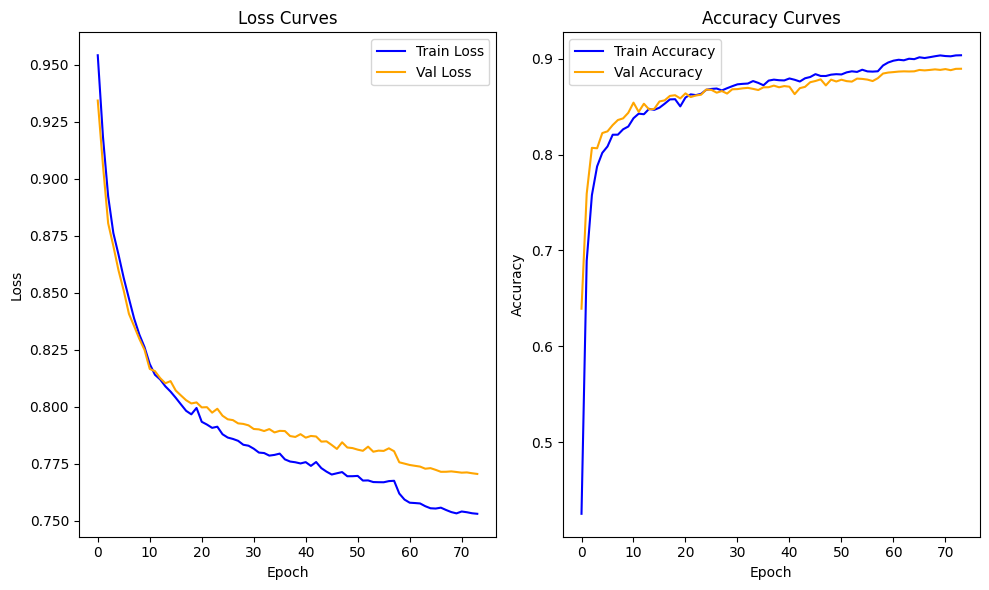

In [34]:
plot_acc_loss(train_accs_fcn,val_accs_fcn,train_loss_fcn,val_loss_fcn)

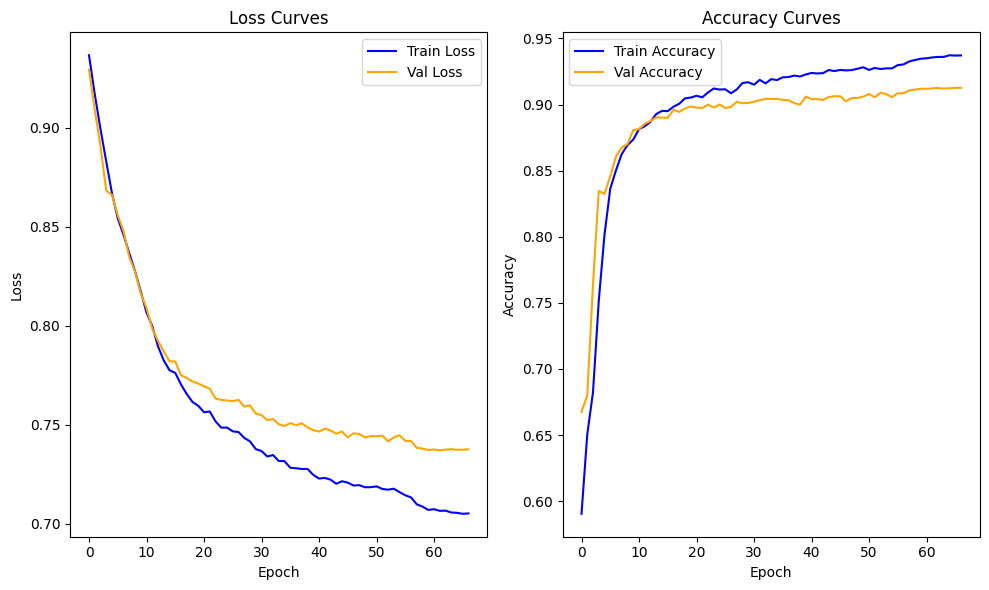

In [35]:
plot_acc_loss(train_accs_unet,val_accs_unet,train_loss_unet,val_loss_unet)

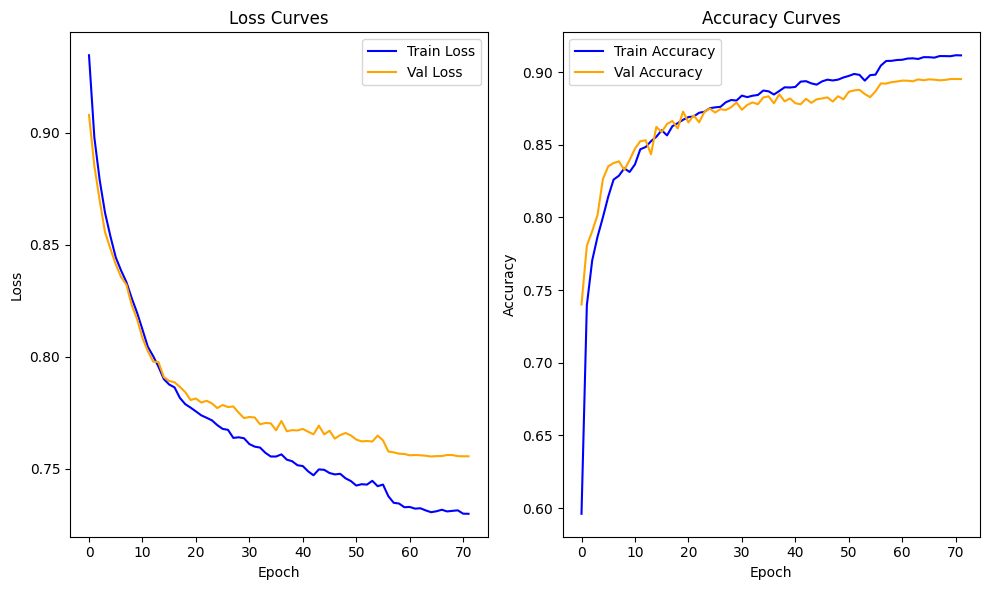

In [36]:
plot_acc_loss(train_accs_deeplab,val_accs_deeplab,train_loss_deeplab,val_loss_deeplab)

# Evaluation

In [37]:
def evaluate_model(model, dataloader):
    model.eval()
    miou_scores = []
    pixel_accuracies = []
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            # Compute mIoU
            miou = jaccard_score(masks.cpu().numpy().flatten(), predictions.cpu().numpy().flatten(), average='macro')
            miou_scores.append(miou)

            # Compute Pixel Accuracy
            pixel_acc = (predictions == masks).sum().item() / (masks.shape[0] * masks.shape[1] * masks.shape[2])
            pixel_accuracies.append(pixel_acc)

            # Collect images, masks, and predictions for visualization
            all_images.append(images.cpu())
            all_masks.append(masks.cpu())
            all_predictions.append(predictions.cpu())

    # Calculate average metrics
    avg_miou = np.mean(miou_scores)
    avg_pixel_acc = np.mean(pixel_accuracies)
    
    print(f'Average mIoU: {avg_miou:.4f}, Average Pixel Accuracy: {avg_pixel_acc:.4f}')

    # Concatenate all collected tensors
    all_images_tensor = torch.cat(all_images)
    all_masks_tensor = torch.cat(all_masks)
    all_predictions_tensor = torch.cat(all_predictions)

    return avg_miou, avg_pixel_acc, all_images_tensor, all_masks_tensor, all_predictions_tensor


## Average mIoU

In [38]:
# Evaluate the model and get predictions
avg_miou_fcn, avg_pixel_acc_fcn, images, masks, predictions_fcn = evaluate_model(model_fcn, test_loader)
print(f'Test mIoU on fcn : {avg_miou_fcn:.4f}, Test Pixel Accuracy: {avg_pixel_acc_fcn:.4f}')

Average mIoU: 0.3414, Average Pixel Accuracy: 0.8585
Test mIoU on fcn : 0.3414, Test Pixel Accuracy: 0.8585


In [39]:
avg_miou_unet, avg_pixel_acc_unet, images, masks, predictions_unet = evaluate_model(model_unet, test_loader)
print(f'Test mIoU on unet: {avg_miou_unet:.4f}, Test Pixel Accuracy for unet: {avg_pixel_acc_unet:.4f}')

Average mIoU: 0.4572, Average Pixel Accuracy: 0.8817
Test mIoU on unet: 0.4572, Test Pixel Accuracy for unet: 0.8817


In [40]:
avg_miou_deeplab, avg_pixel_acc_deeplab, images, masks, predictions_deeplab = evaluate_model(model_deeplab, test_loader)
print(f'Test mIoU on deeplab: {avg_miou_deeplab:.4f}, Test Pixel Accuracy for deeplab: {avg_pixel_acc_deeplab:.4f}')

Average mIoU: 0.3813, Average Pixel Accuracy: 0.8637
Test mIoU on deeplab: 0.3813, Test Pixel Accuracy for deeplab: 0.8637


## Visualize predictions

In [41]:
def visualize_predictions(images, masks, predictions, color_mapping, num_images=3):
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}  # Reverse the mapping for easy lookup

    for i in range(min(num_images, len(images))):
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy().transpose(1, 2, 0))  # Assuming images are in CHW format
        plt.title('Original Image')
        plt.axis('off')

        # Ground Truth Mask (RGB)
        plt.subplot(1, 3, 2)
        gt_mask_rgb = class_to_rgb(masks[i].numpy(), reverse_color_mapping)
        plt.imshow(gt_mask_rgb)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted Mask (RGB)
        plt.subplot(1, 3, 3)
        pred_mask_rgb = class_to_rgb(predictions[i].numpy(), reverse_color_mapping)
        plt.imshow(pred_mask_rgb)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()



In [42]:
def class_to_rgb(mask, reverse_color_mapping):
    """Convert class indices to RGB values using the reverse color mapping."""
    height, width = mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, rgb in reverse_color_mapping.items():
        rgb_mask[mask == class_idx] = rgb

    return rgb_mask

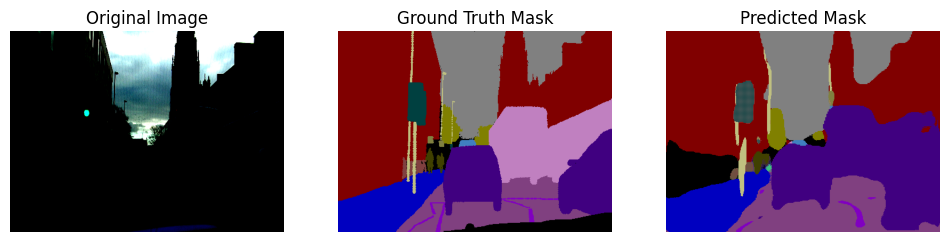

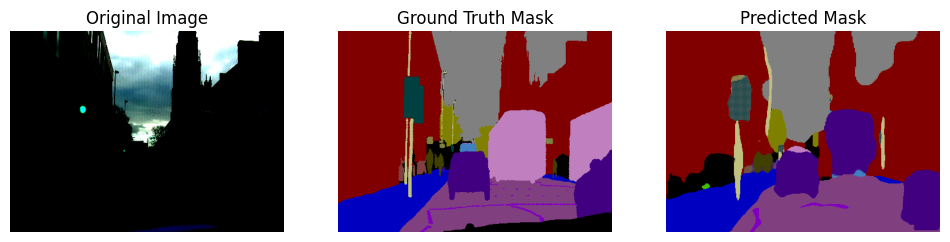

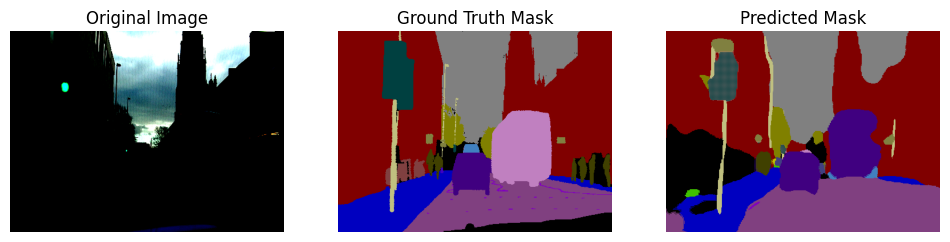

In [43]:
visualize_predictions(images, masks, predictions_fcn, color_mapping, num_images=3)

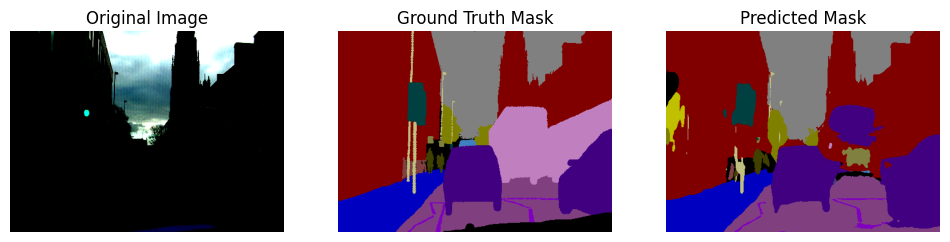

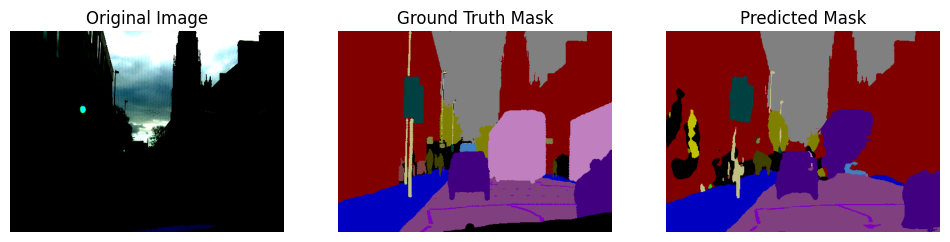

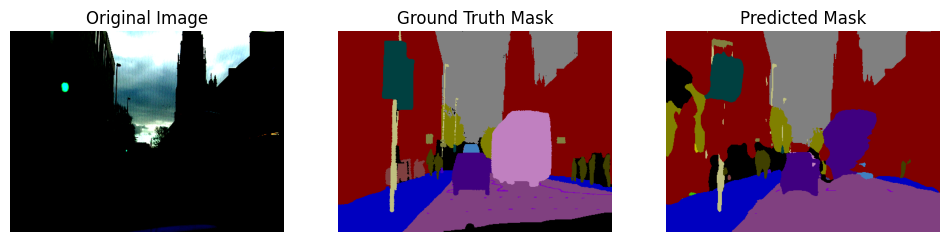

In [44]:
visualize_predictions(images, masks, predictions_unet, color_mapping, num_images=3)

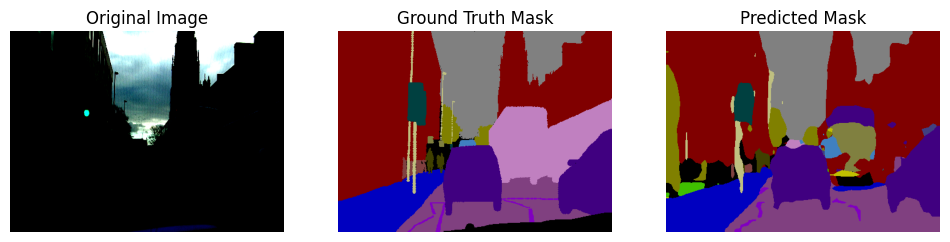

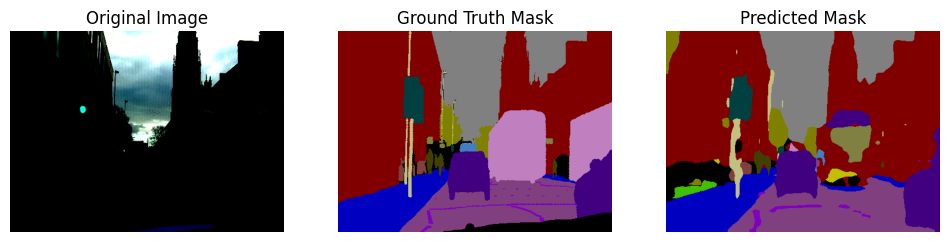

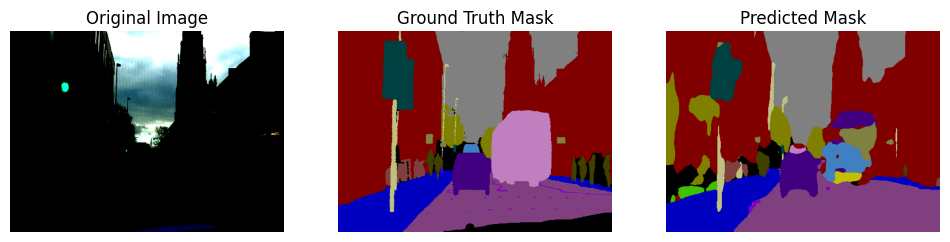

In [45]:
visualize_predictions(images, masks, predictions_deeplab, color_mapping, num_images=3)